<a href="https://colab.research.google.com/github/ipavlopoulos/palit/blob/main/train_fcnnc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# fCNNc 
* A CNN classifier using a fragmentation-based augmentation strategy
* Train/val/test split respects the information about the papyri the lines were taken from, avoiding data leaking 

In [1]:
#@title Importing
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from skimage import transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import *
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb 

from tqdm.notebook import tqdm
import os
import random

In [2]:
#@title Source: The architecture

class CNNCLF(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.CNN = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
        )
        
        self.MLP = nn.Sequential(
            nn.Linear(41472, 1024, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.1, inplace=True),
            
            nn.Linear(1024, 512, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.1, inplace=True),
            
            nn.Linear(512, n_classes, bias=True)
        )
        
    def forward(self, x):
        x = self.CNN(x.unsqueeze(1))
        x = torch.flatten(x, 1)
        x = self.MLP(x)
        return x

In [89]:
#@title Source: The training procedure
# the model predicts the average - high variance
def validate_clf(model, dataloader, device="cpu", criterion = nn.CrossEntropyLoss()):
    prediction_list, labels_list = [], []
    model.eval()
    loss = 0
    with torch.no_grad():
        for id_batch, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            model.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            labels = np.argmax(labels.cpu().detach().numpy(), axis=1)
            predictions = np.argmax(outputs.cpu().detach().numpy(), axis=1)
            prediction_list.append(predictions)
            labels_list.append(labels)
        loss /= id_batch # <= averaging
    p = np.concatenate(prediction_list)
    g = np.concatenate(labels_list)
    acc = accuracy_score(g, p)
    f1 = f1_score(g, p, zero_division=0, average='macro')
    return p, g, loss, acc, f1

def train_clf(model, dataloader, optimizer, criterion=nn.CrossEntropyLoss(), val_dataloader=None, patience=3, N_EPOCHS=100, device="cpu", epochs_no_action=10):
    losses, mae_losses, val_losses, train_losses = [], [], [], []
    dataset_size = len(dataloader.dataset)
    lowest_error = 100000
    highest_score = 0
    best_epoch = -1
    
    for epoch in range(N_EPOCHS):
        print(f"Epoch {epoch + 1}\n-------------------------------")
        train_loss = 0
        # Loop over batches in an epoch using DataLoader
        for id_batch, (inputs, labels) in enumerate(dataloader):
            model.train()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= id_batch # <= averaging

        if val_dataloader is not None:
            if (patience>0) and (epoch-best_epoch>patience-1) and epoch>epochs_no_action:
                print("Max patience reached, now loading the best checkpoint...")
                model.load_state_dict(torch.load("checkpoint.pt"))
                print("Exiting...")
                break
            predictions, labels, val_loss, val_acc, val_f1 = validate_clf(model, val_dataloader, device=device)
            val_losses.append(val_loss)
            train_losses.append(train_loss)
            if (patience>0) and (val_f1>highest_score):
                highest_score = val_f1
                best_epoch = epoch
                torch.save(model.state_dict(), "checkpoint.pt")
            print(f"Train loss: {train_loss:.2f}, Val loss: {val_loss:.2f}, Val acc: {val_acc:.2f}") 
            print(f"Best Epoch: {best_epoch+1} (Val F1: {highest_score:.2f})") 
            print(f"[val var: {np.var(predictions):.2f}, min-max: {min(predictions):.2f}-{max(predictions):.2f}, F1: {val_f1}]")
    model.eval()
    return model, train_losses, val_losses

In [4]:
#@title Source: The dataset wrapper
class ImageDataset(TensorDataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = np.array(self.dataframe['date'])
        self.labels = np.reshape(self.labels, (self.labels.shape[0], 1))
        self.labels = OneHotEncoder(sparse_output=False).fit_transform(self.labels)
        
    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        sample, date = self.dataframe.iloc[idx].img.astype(np.float32), self.labels[idx]
        if self.transform is not None:
            sample = self.transform(sample)
            sample = sample.reshape(sample.shape[1], sample.shape[2]) # grayscale
        return sample, date # 1CE-4CE

In [5]:
#@title Source: Augmentation

augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(3), # turn
    transforms.RandomResizedCrop((50, 300), scale=(0.75, 1.0), ratio=(1, 6)), # crop n scale (add scale to control this)
    #transforms.RandomCrop((30, 30)),
    transforms.GaussianBlur(3), # blur
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, value=0.5), # erase
])

cc_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((50, 300)),
    transforms.ToTensor(),
])

rs_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50,300)),
    transforms.ToTensor(),
])

white_fragment_ablation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50,300)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=1, value=0), # erase
])

black_fragment_ablation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50,300)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=1, value=1), # erase
])

### Loading the data
* Load the data (papyri fragments)
* Explode to lines
* Split without leaking information about the scribe

In [6]:
%%capture
# ACTION needed: download the data (with gdown) or re-create from PaLit.xlsx
pll = pd.read_pickle("pll.csv")

In [7]:
dataset = pll.explode("img")
dataset = dataset[dataset.img.notna()]

In [8]:
print("Lines num:", dataset.shape[0])

w,h = 300,50
img_data = pd.DataFrame(dataset.img.apply(lambda x: x.shape).tolist(), index=dataset.index, columns=["H", "W"])
dataset = dataset[(img_data.W>w)&(img_data.H>h)]
dataset.insert(0, "lid", range(1, dataset.shape[0]+1))

Lines num: 4717


2615 79 80


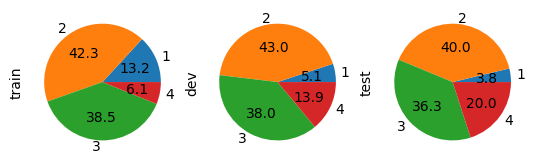

In [85]:
# Data split with non-exclusive fragments between train, val, test
#pll_train, pll_test = train_test_split(dataset, test_size=0.1, random_state=2023)
#pll_train, pll_val = train_test_split(pll_train, test_size=pll_test.shape[0], random_state=2023)

# Train, dev, test lines taken from different fragments
testmod = 13
pll_test = dataset[dataset.uid%testmod==0]
pll_test, pll_val = train_test_split(pll_test, test_size=pll_test.shape[0]//2, random_state=2021)
pll_train = dataset[dataset.uid%testmod!=0]

print(pll_train.shape[0], pll_val.shape[0], pll_test.shape[0])
pd.DataFrame({"train": pll_train.date.value_counts(),                
              "dev": pll_val.date.value_counts(),
              "test":pll_test.date.value_counts()}).plot.pie(subplots=True, autopct=f'%.1f', legend=False);


### Training

Epoch 1
-------------------------------
Train loss: 1.22, Val loss: 1.98, Val acc: 0.38
Best Epoch: 1 (Val F1: 0.14)
[val var: 0.00, min-max: 2.00-2.00, F1: 0.13761467889908258]
Epoch 2
-------------------------------
Train loss: 1.06, Val loss: 1.41, Val acc: 0.68
Best Epoch: 2 (Val F1: 0.38)
[val var: 0.24, min-max: 1.00-2.00, F1: 0.37885680379746833]
Epoch 3
-------------------------------
Train loss: 1.02, Val loss: 1.67, Val acc: 0.38
Best Epoch: 2 (Val F1: 0.38)
[val var: 0.00, min-max: 2.00-2.00, F1: 0.13761467889908258]
Epoch 4
-------------------------------
Train loss: 0.99, Val loss: 3.42, Val acc: 0.38
Best Epoch: 2 (Val F1: 0.38)
[val var: 0.00, min-max: 2.00-2.00, F1: 0.13761467889908258]
Epoch 5
-------------------------------
Train loss: 0.96, Val loss: 1.42, Val acc: 0.58
Best Epoch: 2 (Val F1: 0.38)
[val var: 0.16, min-max: 1.00-2.00, F1: 0.32129032258064516]
Epoch 6
-------------------------------
Train loss: 0.98, Val loss: 1.69, Val acc: 0.53
Best Epoch: 2 (Val F1:

<Axes: >

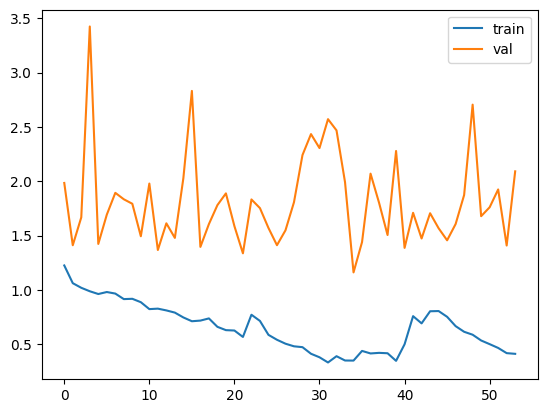

In [91]:
epochs, batch_size, device, n_classes, lr, patience = 150, 32, "cuda", 4, 1e-3, 20
dataloader = DataLoader(ImageDataset(pll_train, transform=augment), batch_size=batch_size, drop_last=False, shuffle=True)
val_dataloader = DataLoader(ImageDataset(pll_val, transform=rs_transform), batch_size=batch_size, drop_last=False)
model = CNNCLF(n_classes=n_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
model, train_losses, val_losses = train_clf(device=device, dataloader=dataloader, model=model, optimizer=optimizer, N_EPOCHS=epochs, val_dataloader=val_dataloader, patience=patience)
pd.DataFrame({"train": train_losses, "val": [float(v) for v in val_losses]}, index=range(len(train_losses))).plot()

### Eval

Acc: 0.72
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.80      0.75      0.77        32
           2       0.64      0.79      0.71        29
           3       0.83      0.62      0.71        16

    accuracy                           0.73        80
   macro avg       0.69      0.63      0.65        80
weighted avg       0.74      0.72      0.72        80



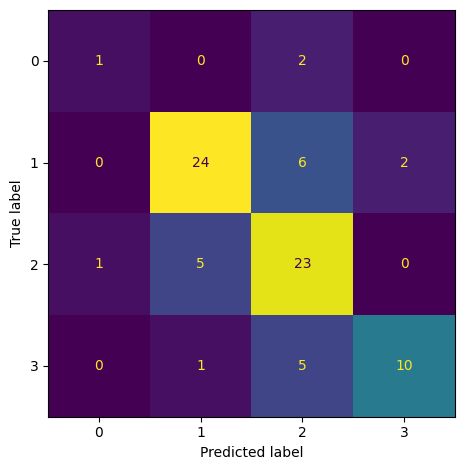

In [101]:
model = CNNCLF(n_classes=n_classes).to(device)
model.load_state_dict(torch.load("checkpoint.pt"))

test_loader = DataLoader(ImageDataset(pll_test, transform=rs_transform), batch_size=1)
predictions, labels, loss, acc, f1 = validate_clf(model, test_loader)
print(f'Acc: {acc:.2f}')
print(classification_report(labels, predictions))
ax = ConfusionMatrixDisplay.from_predictions(labels, predictions, colorbar=False);
plt.tight_layout();
ax.figure_.savefig('confusion.pdf', format='PDF', dpi=300)

In [102]:
#@title [Optional] Saving
 # saving the trained model to your drive
from google.colab import drive
drive.mount('/content/gdrive')
!cp checkpoint.pt gdrive/MyDrive/fcnnc.pt 

# saving the data
pll_test[pll_test.columns[:-1]].to_csv('test.csv')
pll_train[pll_train.columns[:-1]].to_csv('train.csv')
pll_val[pll_val.columns[:-1]].to_csv('val.csv')
!cp test.csv gdrive/MyDrive/pll_xsplit_test.csv

# Download the checkpoint
#net = CNNCLF(4) # <-- loading
#net.load_state_dict(torch.load("gdrive/MyDrive/fcnnc.pt", map_location=torch.device('cpu')))

Mounted at /content/gdrive


# Saliency

In [103]:
# !rm -R heatmaps 
!mkdir heatmaps
dataloader = DataLoader(ImageDataset(pll_test, transform=rs_transform), batch_size=1)
device = 'cpu'
criterion = nn.CrossEntropyLoss().to(device)
model.eval()
for batch_index, (batch, labels) in enumerate(dataloader):
    batch = batch.to(device)
    labels = labels.to(device)
    batch = batch.requires_grad_(requires_grad=True)
    
    output = model(batch).to(device)
    loss = criterion(output, labels)

    loss.backward()
  
    batch_grad = batch.grad.cpu().detach().numpy()
    batch_grad = np.squeeze(batch_grad)
    batch_grad = np.absolute(batch_grad)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    axs[0].imshow(batch_grad, cmap='hot', interpolation='nearest')
    axs[1].imshow(np.squeeze(batch.cpu().detach().numpy()), cmap='gray')

    # plt.colorbar()
    plt.savefig(f'./heatmaps/heatmap_{batch_index:d}-DATE:{pll.iloc[batch_index].date}-PRED:{np.argmax(output.detach(), 1)}')
    plt.close()

# Ablation
* Using the fragmentation-based augmentation to patch with black and white boxes.

In [ ]:
# black box patch (the name is mistaken in the lib)
!mkdir ablations
dataloader = DataLoader(ImageDataset(pll_test.iloc[:batch_size], transform=white_fragment_ablation), batch_size=1)
device = 'cpu'
criterion = nn.CrossEntropyLoss().to(device)
model.eval()
for batch_index, (batch, labels) in enumerate(dataloader):
    batch = batch.to(device)
    labels = labels.to(device)
    batch = batch.requires_grad_(requires_grad=True)
    
    output = model(batch).to(device)
    loss = criterion(output, labels)

    loss.backward()
  
    batch_grad = batch.grad.cpu().detach().numpy()
    batch_grad = np.squeeze(batch_grad)
    batch_grad = np.absolute(batch_grad)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    axs[0].imshow(batch_grad, cmap='hot', interpolation='nearest')
    axs[1].imshow(np.squeeze(batch.cpu().detach().numpy()), cmap='gray')

    plt.savefig(f'./ablations/black_{batch_index:d}-DATE:{pll.iloc[batch_index].date}-PRED:{np.argmax(output.detach(), 1)}')
    plt.close()


In [106]:
dataloader = DataLoader(ImageDataset(pll_test.iloc[:batch_size], transform=black_fragment_ablation), batch_size=1)
device = 'cpu'
criterion = nn.CrossEntropyLoss().to(device)
model.eval()
for batch_index, (batch, labels) in enumerate(dataloader):
    batch = batch.to(device)
    labels = labels.to(device)
    batch = batch.requires_grad_(requires_grad=True)
    
    output = model(batch).to(device)
    loss = criterion(output, labels)

    loss.backward()
  
    batch_grad = batch.grad.cpu().detach().numpy()
    batch_grad = np.squeeze(batch_grad)
    batch_grad = np.absolute(batch_grad)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    axs[0].imshow(batch_grad, cmap='hot', interpolation='nearest')
    axs[1].imshow(np.squeeze(batch.cpu().detach().numpy()), cmap='gray')

    plt.savefig(f'./ablations/white_{batch_index:d}-DATE:{pll.iloc[batch_index].date}-PRED:{np.argmax(output.detach(), 1)}')
    plt.close()

In [107]:
%%capture
!zip heatmap.zip heatmaps/*
!zip ablations.zip ablations/* 

# Dating papyri of the 2nd or 3rd CE 

In [108]:
# ACTION needed: download the data (with gdown) or re-create using PaLit.xlsx  # the image lines in doubt
doubtful = pd.read_pickle("doubted.csv")
label_map = {'"-1/1"':0, "-1/1":0, "2,3":2.5, "3,4":3.5, "5,6":5.5, "6,7":6.5}
doubtful.date = doubtful.date.apply(lambda x: label_map[x] if x in label_map else x)

Downloading...
From: https://drive.google.com/uc?id=1majEsBvm_pAyTtHqSGHpI3vnXLViiI5f
To: /content/doubted.csv
100% 1.70G/1.70G [01:15<00:00, 22.6MB/s]


In [109]:
d = doubtful[doubtful.date==2.5]
w,h = 300,50
img_data = pd.DataFrame(d.img.apply(lambda x: x.shape).tolist(), index=d.index, columns=["H", "W"])
d = d[(img_data.W>w)&(img_data.H>h)]

In [111]:
def predict(model, dataloader, device="cpu"):
  predictions = []
  model.eval()
  with torch.no_grad():
      for id_batch, (inputs, labels) in enumerate(dataloader):
          inputs = inputs.to(device)
          outputs = model(inputs)
          predictions.append(outputs.cpu().numpy()[0])
  return predictions 

test_loader = DataLoader(ImageDataset(d, transform=rs_transform), batch_size=1)
predictions = predict(model, test_loader)
d.insert(6, "CE", predictions)
d.insert(0, "Papyrus", d.filename_enc.apply(lambda x: x.split("_")[1].replace(".jpg", "").replace(".png", "").replace("picture", "").replace("(1)", "")))

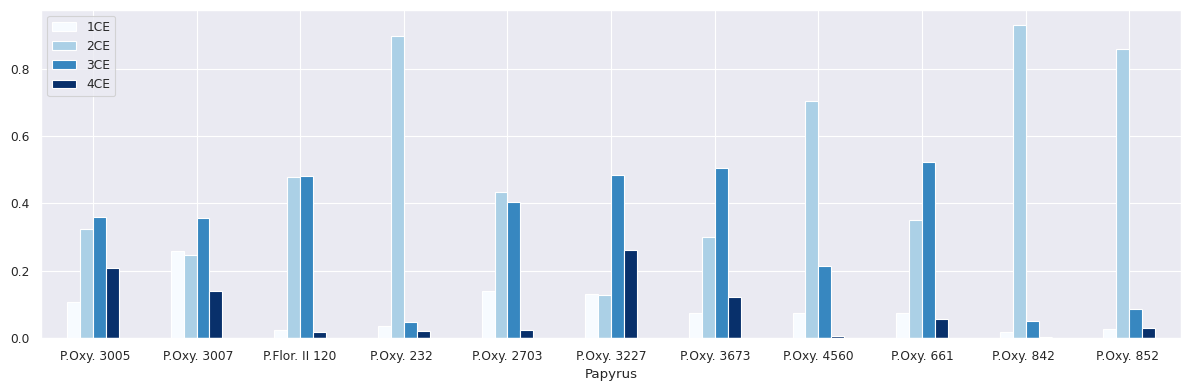

In [112]:
# we could visualise the probability (one per line) per papyrus (11 in total)
import seaborn as sns; sns.set_theme('paper'); 
#sns.set(rc={'figure.figsize':(15,5)})
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)
papyri = list(d.Papyrus.unique())
estimations = pd.DataFrame(d.CE.apply(softmax).apply(pd.Series))
estimations['Papyrus'] = d.Papyrus
g = estimations.groupby('Papyrus')
gg = pd.DataFrame()
gg['1CE'] = g[0].apply(np.mean)
gg['2CE'] = g[1].apply(np.mean)
gg['3CE'] = g[2].apply(np.mean)
gg['4CE'] = g[3].apply(np.mean)
sns.set_style()
ax = gg.plot.bar(figsize=(12,4), colormap='Blues', rot=0);
plt.tight_layout()
ax.figure.savefig('undated.pdf', format='PDF', dpi=300)